# Web scrapping para la caputra de datos de ventas de motos usadas de la marca Agility 125

Mediante el uso de la libreria selenium se obtendran datos de la página de ventas "olx". Dichos datos serán limpiados para la creación de un dataframe.


## Captura de datos

In [598]:
from urllib.request import urlopen, Request
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [38]:
#instanciar url 
b=webdriver.Chrome('C:/chromedriver.exe')
url="https://www.olx.com.co/motos_c379/q-agility-?sorting=desc-price"
b.get(url)

In [39]:
#automatizar el click en botton "mostrar mas" para visulizar todos los resultados de la búsqueda
while True:
    time.sleep(1.5)
    try:
        btn=b.find_element_by_class_name("JbJAl").find_element_by_tag_name("button")
        btn.click()
    except NoSuchElementException:
        break
 

In [40]:
#obtener la url de la  pagina de venta de cada cada moto

object_bs=BeautifulSoup(b.page_source)

mean_list=object_bs.find_all("li",{"class":"EIR5N"})
links=[]
for i in mean_list:
    links.append(i.find('a').get('href'))



In [41]:
#instanciar url de cada pagina

url="https://www.olx.com.co"+links[0]


In [42]:
#scraping 
def scraping(url):   
    def load_url(url):
        
        urlopen(url)
        bs=BeautifulSoup(urlopen(url).read())
        return bs
    price=load_url(url).find('span',{'data-aut-id':'itemPrice'}).get_text()
    
    try:    
        year=load_url(url).find('span',{'data-aut-id':'value_year'}).get_text()
    except AttributeError:  
        year=''
        
    try:    
        mileage=load_url(url).find('span',{'data-aut-id':'value_mileage'}).get_text()
    except AttributeError: 
            mileage=''
    try: 
        only_one_owner=load_url(url).find('span',{'data-aut-id':'value_previous_owner'}).get_text()
       
    except AttributeError:
        only_one_owner=''
    
    
    
        
        
        
    row=[year,mileage,only_one_owner,price]  
    return  row

In [43]:
#scraping de las urls 

from urllib.error import HTTPError
from tqdm import tqdm   
data=[]

for url in tqdm(links):
    try:
            item=scraping("https://www.olx.com.co"+url)
            data.append(item)
    except HTTPError :
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 233/233 [26:13<00:00,  6.75s/it]


In [580]:
#creacion de dataframe
df = pd.DataFrame(data, columns = ['model', 'mileage', 'one_owner','price'])


df

,model,mileage,one_owner,price
0,2022,0 km,,$ 7.499.000
1,2019,12.000 km,Sí,$ 5.050.000
2,2022,0 km,,$ 7.999.000
3,2014,0 km,No,$ 3.090.000
4,2022,0 km,,$ 9.799.000
...,...,...,...,...
216,2010,0 km,Sí,$ 1.700.000
217,2011,45.000 km,No,$ 1.450.000
218,2013,123.546 km,Sí,$ 1.234.567
219,2016,52.000 km,,$ 1.234.567


## Limpieza de datos

In [581]:
#eliminar filas con datos vacios 
df.drop(df[(df.mileage=="")  |  (df.one_owner=="")|  (df.price=="")|  (df.model=="")].index,inplace=True)


In [582]:
#funciones para limpiar el formato de los datos
def clean_mileage(col):
    col=col.replace('km','').strip()
    col=col.replace('.','')
    col=int(col)
    return col
def clean_price(col):
    col=col.replace('$','').strip()
    col=col.replace('.','')
    col=int(col)
    return col
    
   


In [583]:
#aplicar funciones sobre los datos
df['mileage']=df['mileage'].apply(lambda x:clean_mileage(x))
df['price']=df['price'].apply(lambda x:clean_price(x)) 
df['model']=df['model'].astype("int64")



### Exploración de datos atípicos 

In [584]:
df.isnull().sum()

model        0
mileage      0
one_owner    0
price        0
dtype: int64

In [585]:
#modelo
df.model.unique()


array([2019, 2014, 2022, 2020, 2021, 2016, 2017, 2018, 2015, 2013, 2012,
       2011, 2010, 2009, 2008], dtype=int64)

No se observan datos incosistentes para los años de los modelos. 

count    2.060000e+02
mean     4.184391e+06
std      1.581349e+06
min      5.000000e+05
25%      3.125000e+06
50%      3.800000e+06
75%      5.037500e+06
max      9.680000e+06
Name: price, dtype: float64

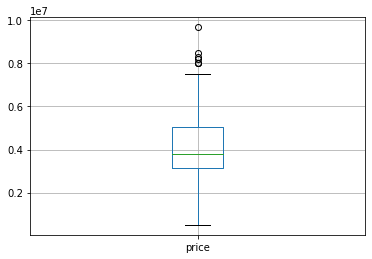

In [586]:
#precio
df.boxplot(column="price")
df.price.describe()

Notamos algunos valores atipicos.

In [587]:
# detallar valores altos
df[df.price>8000000]


,model,mileage,one_owner,price
5,2022,1575,Sí,9680000
7,2020,6216,Sí,8500000
8,2021,5000,Sí,8300000
9,2022,1000,Sí,8200000


Se observa un valor especialmente alto 

In [588]:
#eliminar valor atipico 
df.drop(5,inplace=True)

count       205.000000
mean      36166.258537
std       52611.420702
min           0.000000
25%       10000.000000
50%       26000.000000
75%       47200.000000
max      409301.000000
Name: mileage, dtype: float64

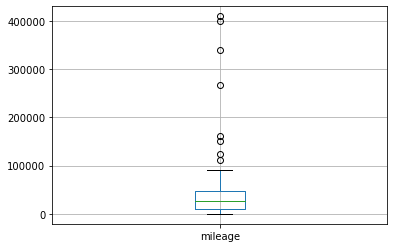

In [589]:
#kilometraje 

df.boxplot(column="mileage")
df.mileage.describe()

In [590]:
#valores muy altos 
df[(df.mileage>100000)]

,model,mileage,one_owner,price
99,2019,266621,Sí,4000000
146,2013,150000,Sí,3400000
154,2013,400000,No,3200000
166,2016,340400,Sí,3000000
185,2011,409301,No,2800000
205,2009,111111,No,2200000
214,2009,161000,Sí,1800000
218,2013,123546,Sí,1234567


In [591]:
#eliminar valores atipicamente altos
df.drop(df[(df.mileage>100000)].index,inplace=True)

In [592]:
#valores muy bajos o cero 

df[(df.mileage<500) & (df.model<2022)].sort_values("model")


,model,mileage,one_owner,price
210,2009,0,No,2000000
213,2009,320,No,1850000
216,2010,0,Sí,1700000
188,2011,58,No,2800000
115,2012,0,No,3800000
209,2013,123,No,2100000
200,2013,125,Sí,2400000
159,2013,60,No,3200000
157,2013,124,Sí,3200000
152,2013,25,Sí,3300000


La mayoria de estos valores se deben a errores de digitación o que el campo  no es llenado correctamente.



In [595]:
#ordenamos por precio y modelo
df.sort_values(["model","price"],ignore_index=True,inplace=True)
df

,model,mileage,one_owner,price
0,2008,13000,Sí,1900000
1,2009,88000,No,1700000
2,2009,320,No,1850000
3,2009,0,No,2000000
4,2009,20000,Sí,2200000
...,...,...,...,...
192,2022,23000,Sí,7400000
193,2022,632,Sí,7500000
194,2022,3500,Sí,8000000
195,2022,130,Sí,8000000


In [596]:
#remplacemos los valores atipicamente bajos con el valor de la entrada anterior 
df.mileage=df.mileage.apply(lambda x: 0 if x <500 else x)
df.replace([0], np.NaN,inplace=True)
df.fillna(method="ffill",inplace=True)

In [597]:
#Guardar dataframe
df.to_csv('olx_date.csv',index=False)
df=pd.read_csv('olx_date.csv')
df

,model,mileage,one_owner,price
0,2008,13000.0,Sí,1900000
1,2009,88000.0,No,1700000
2,2009,88000.0,No,1850000
3,2009,88000.0,No,2000000
4,2009,20000.0,Sí,2200000
...,...,...,...,...
192,2022,23000.0,Sí,7400000
193,2022,632.0,Sí,7500000
194,2022,3500.0,Sí,8000000
195,2022,3500.0,Sí,8000000
